#  A model to predict daily new Covid19 cases and to estimate the spread of the disease : A DSP approach

In the wake of the Covid19 outbreak there has been a lot of attention in press and poopular media on mathematical models used in epidemiology to predict spread of infectious diseases. [Epidemic Caluclator](https://gabgoh.github.io/COVID/index.html) [Kucharski et al. 2020](https://cmmid.github.io/topics/covid19/current-patterns-transmission/wuhan-early-dynamics.html) [Mandal et al. 2020](https://www.ncbi.nlm.nih.gov/pubmed/3220226) [Klein et al. 2020](https://cddep.org/covid-19/)

The underlying mathematical models behind studies such as above are described in an artcle by Hethcote [Hethcote 2000] (https://dl.acm.org/doi/10.1137/S0036144500371907). Among these, are SEIR and SIR models. The SIR model propose that, in the wake of an infectious disease, there is a flow of individuals through a number of distinct stages : S(people not infected but suspectible to the disease) -> I (infected people and capable of causing additional infections) -> R(those who recovered and will not cause additonal infections). The SEIR model adds another stage E between S and I, representing the set of people who are already infected but not infectious. This is applicable for infectious diseases which show a delay between being infected but not yet infectious. These models aree also described in https://www.idmod.org/docs/hiv/model-seir.html and https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology 

In these models, S, E, I, R are expressed as continuous time variables and differential equals are solved to predict characteristics of the disease spread such as total infected, peak infected, rate of spread etc. This is because various parameters such as incubation period, infectious period are continuous variable, taking non-discrete fractional values. 

I have no background in epidemiolgy. But, as an engineer, I am familiar with processing of discrete time domain data through the well-studied field of Digital Signal Processing (DSP). In this notebook, I am using DSP formulations and methods to understand how an epidemic like Covid19 can spread and how well it is being contained. Following are my assumptions :

* Once a person X gets infected, it takes N days for her to feel sick.
* With these N days, the infected person will infect R more persons. 
* Once the person X feels sick, she will self-report, be tested and counted among daily new cases. 
* After N days, person X will self-quarantine and not infecting others.


Now, R is not a constant but varies over time. As per epidemiological models, R depends upon S, the number of people who haven't been infected *yet* but are susceptible. The rational is that at the beginning of the epidemic, when there are lots of people susceptible, one infected person infects more people. While towards the end when most people have already been infected or recovered, number of infections caused by one infected is going to be less. In this notebook, I have considered R as proportional to S, as per epidemiological models [Hethcote 2000] (https://dl.acm.org/doi/10.1137/S0036144500371907).

To mathematically formulate these assumptions, let:

`
S(n) = number of suscptible people at day n
I(n) = number of new infections caused on day n
R(n) = number of new infections caused by an infected person X on day n
N = number of days for which the infected person X causes new infections.
r(n) = R(N)/N = number of new infections caused per day by an infected person X on day n.
`

A person X gets infected on day k. Now, she will unknowingly keep infecting others on day k+1, k+2, ..., k+N, until she starts feeling sick. The rate at which the infections happen on each day can also change : r(k+1),r(k+2),...,r(k+N) respectively for each day k+1 to k+N. 

Under these assumptions, I(n) can be represented as follows :

`
I(n) = r(n) * I(n-1) + r(n) * I(n-2) + .... + r(n) * I(n-N)
`

The equation for I(n) is a time varying IIR (Infinite Impluse Response) filter in the field of DSP. 

As per the above assumptions, the people who gets infected on day n will be tested and counted as positive cases N days later. So, C(n), the number of new cases reported on day n can be expressed as :

`I(n) = C(n+N) => I(n-N) = C(n)` 

Since C(n) is just a phase shifted version of I(n) :

`
C(n+N) = r(n) * C(n-1+N) + r * C(n-2+N) + .... + r(n) * C(n-N+N)
C(n) = r(n-N) * C(n-1) + r(n-N) * C(n-2) + .... + r(n-N) * C(n-N)
`

Thus, we can use this model to predict number of new cases likely to be seen on day n, given the numbers of new cases for N days before day n, if we also have an estimate of R(n-N) = N * r(n-N). Alternatively, given the series of daily new cases, one can estimate R(N) and provide an indication of how fast or slow the disease is spreading. Thus,

`
r(n-N) = C(n)/(C(n-1)+...+C(n-N))   
`

Now, as explained before, r(n) depends on susceptible population S(n), decreasing as S(n) as the epidemic progresses. It also depends upon the rate at which contacts are happenning with an infected person. And this contact rate could change as various public health strategies such as social distancing and lockdown are deployed or withdrawn. To separate these two factors, r(n) can further be expressed as a product of two factors :

`r(n) = q(n) * S(n-1)`

where, q(n) represents the number of new infections caused on day n by 1 infected person if there was only 1 susceptible person left on that day. It is referred to as effective contact rate [Jones et al. 2007](https://web.stanford.edu/~jhj1/teachingdocs/Jones-on-R0.pdf). 

It follows that:

`
r(n) = q(n) * S(0) * (S(n-1)/S(0))
Multiplying by N :
R(n) = R'(n) * S(n-1)/S(0)
=> R(n) = R'(n) * R_Adjust_Factor(n)
`

In literature, R is called effective reproductive number and alternatively as replacement number of an infection [Lipsitch et al.](https://www.ncbi.nlm.nih.gov/pubmed/127662070) [Hethcote 2000](https://dl.acm.org/doi/10.1137/S0036144500371907). Since `R'(n) = q(n) * N * S(0)` does not depend upon S(n), it can be used as a measure of effective contact rate. R_Adjust_Factor(n) is an adjustment factor to account for the progress of the epidemic. Apart from termilogies used in literature, in this notebook, I will also refer to R loosely as the rate of infection spread and to R' as adjusted rate of infection spread, with R_Adjust_Factor being the adjustment factor. 

Note at the very beginning of the epidemic `R(0) = R'(0) = q(0) * N * S(0)`. This is referred to as basic reproductive number Ro, widely used in popular media in context of  Covid19 outbreak, and represents the number of new infections directly caused by first infected person at the very beginning of the epidemic.

`
R_Adjust_Factor(n) = S(n-1)/S(0)
S(n-1) = S(n-2) + I(n-1) = S(0) - T(n-1)
=> R_Adjust_Factor(n) = (1 - T(n-1)/S(0))
`

where, T(n) = total number of people infected on day n since the beginning of the epidemic.  And since `I(n) = C(n+N)`, T(n) = total number of positive cases reported on day n+N since the beginning, i.e, 

`
T(n) = sum(C(0),..,C(n+N))
T(n-N) = sum(C(0),..,C(n))
`

In the rest of the notebook, I have analysed publicly available data for Covid19 outbreak from a few geograhical locations such as New York City, Travis County TX and India. For each such location, first I have predicted daily new cases as per this model and compared it with daily reported cases. Second, I have estimated value of R', adjusted replacement number over time to get an indication of the rate at which infection is spreading. 

## Generalization and Limitations of the model

As noted above, a number of assumptions have been used. Let us example some of the assumptions:

* It is assumed that every one who falls sick will self-qurantine. What if everyone does not self-report?
  - If every one does not self-report, they will keep infecting others, simply increasing R and N
* It is assumed that every who falls sick will be tested and counted as new case. This is certainly not the reality. What about inadequate testing?
  - Assume a fraction f of infections are reported and tested. Thus `f * I(n) = C(n)`. Thus the equation for C(n) still remains valid, as long as f does not change too quickly.
* What about difference between incubation and infectious period?
  - In epidemiology, incubation period is different from infectious period. Incubation period is the time from getting infected to showing symptoms. Infectious period is time when a person can cause in infections to others. In general, infectious period can start within the incubation period and may continue well after incubation period. For the purpose of this modeling, incubation period can be made equal to infectious period, and any difference caused may be folded into the parameter r, rate of infections per day. 
* What if N is a not a whole number but a fraction, which is most likely?
  - This model is useful if N, infectious period, is a whole number. This is the case for Covid19, in which, it is said to be 5.2. However, it may be possible to use a ceiling (i.e., next whole number) and  account for the difference through change in r. This requires further work.


In [1]:
from scipy.signal import lfilter
import numpy as np
import datetime as dt
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
np.set_printoptions(suppress=True)

def get_days(start_date, num_days) :
    end_date = start_date + dt.timedelta(days=num_days)
    x = np.arange(start_date, end_date, dt.timedelta(days=1)).astype(dt.datetime)
    return x

def calc_Cn(R_n_N, N, lastN_C) :
    """ Estimate new cases on day n, given new cases for last N days
    where N = incubation  period
    inputs :
    R_n_N = replacement number for day n-N
    lastN_C = daily new cases for last N days [C(n-N),...,C(n-1)]
    N = incubation period in days, same as length of lastN_C
    output :
    Cn = new infections caused on nth day
    The model : 
    r(n-N) = R_n_N / N
    => C(n) = r(n-N) * C(n-1) + r(n-N) * C(n-2) + .... + r(n-N) * C(n-N)
    """
    r = R_n_N / N
    assert(N == len(list(lastN_C)))
    return r * sum(lastN_C)

def calc_R_Adjust_Factor(Tn, S0) :
    '''calculate the adjustment factor R due to change number of susceptibles
    inputs:
    S0 : number of susceptibles at day 0 
    Tn : total number of positive cases by day n 
    '''
    return (1 - Tn/S0)

def predict_daily_new_cases(R0, N, C, S0=0) :
    """ predict daily new cases for the purpose of comparsion with actual
    daily cases. New cases for nth day is predicted from data for day n-1
    and older.
    Inputs :
    R0 = basic reproductive number
    C = reported daily new cases.
    N = incubation period
    S0 = total number of susceptibles on day 0 of the epidemic. If S0 is 0,
    then no adjustment is done to R0
    Output :
    pred_C : predicted daily new cases
    pred_C[0] is predicted new cases on day N.
    If last data point of C, C[-1], represents the number new cases for day x,
    last data point of pred_C, pred_C[-1], represents the predicted new cases
    for day x+1, i.e., len(pred_C) = len(C) + 1 
    
    To calculate pred_C[i], predicted new cases for day N+i (n=N+i), we need 
    to calculate R adjustment factor for day n-N = N+i-N = i, R_adjust_factor(i), 
    for which we need T(i-1) = sum(C(0),..,C(i+N-1)) = sum(C[0:i+N])
    
    R_adjust_factor(0) must be 1
    """
    pred_C = []
    num_predictions = len(C)-N+1    
    for i in range(0,num_predictions) :
        if (S0 == 0) or (i == 0):
            adjust_f = 1
        else :    
            # calculate adjustment factor
            T = sum(C[0:i+N])
            adjust_f = calc_R_Adjust_Factor(T, S0)
        R = R0 * adjust_f
        x = calc_Cn(R0, N, C[i:i+N])
        pred_C.append(x)
    return np.array(pred_C)

def calc_daily_R_adjust_factor(C, S0=0) :
    adjust_f = []
    num_points = len(C)-N+1    
    for i in range(0,num_points) :
        if (S0 == 0) or (i == 0):
            x = 1
        else :    
            # calculate adjustment factor
            T = sum(C[0:i+N])
            x = calc_R_Adjust_Factor(T, S0)
        adjust_f.append(x)
    return np.array(adjust_f)

def estimate_R(Cn, lastN_C, N) :
    """ Estimate rate of disease spread R
    Inputs :
    Cn  = daily new cases on day n
    lastN_C = daily new cases for day n-1 to day n-N
    N = incubation period
    Output :
    R disease spreading rate. This represents R, not
    for day n, but for day n-N. 
    """
    assert(len(lastN_C) == N)
    try :
        r = Cn/sum(lastN_C)
        return r * N
    except ZeroDivisionError :
        return float("nan")

def estimate_daily_R(C, N, S0) :
    """Given daily new cases days 1 to n, estimate rate of  
    disease spread R for days 1 to n-N, where N is incubation period
    """
    est_R = []   
    for i in range(N,len(C)) :
        #print(i)
        x = estimate_R(C[i], C[i-N:i], N)
        if (S0 == 0) or (i == N):
            adjust_f = 1
        else :    
            # calculate adjustment factor
            T = sum(C[0:i+N])
            adjust_f = calc_R_Adjust_Factor(T, S0)
            
        est_R.append(x * adjust_f)
    return np.array(est_R)

def get_daily_new_from_total_cases(T) :
    ''' get a series of new cases per day 
    from the series of total cases per day'''
    diff = T[1:] - T[0:-1]
    C = np.append([T[0]],diff)
    return C

num_figs = 0

## Analysis of Covid19 Data From New York City

In [2]:
#  source ; https://www1.nyc.gov/assets/doh/downloads/pdf/imm/covid-19-daily-data-summary.pdf
nyc_daily_total_cases = np.array([1,1,2,2,4,7,12,14,25,32,53,88,137,185,269,464,923,2009,3954,5683,8115,10764,13119,15597,20011,23112,26697,30765,33474,38087])
start_date=dt.datetime(2020,3,1)

In [3]:
# total cases per day
T = np.array(nyc_daily_total_cases)
# new cases per day
C = get_daily_new_from_total_cases(T)
start_date_str = start_date.strftime("%-m/%-d/%y")
num_days = len(C)
print("Number of data points: {} starting from {}".format(num_days, start_date_str))

Number of data points: 30 starting from 3/1/20


<IPython.core.display.Javascript object>


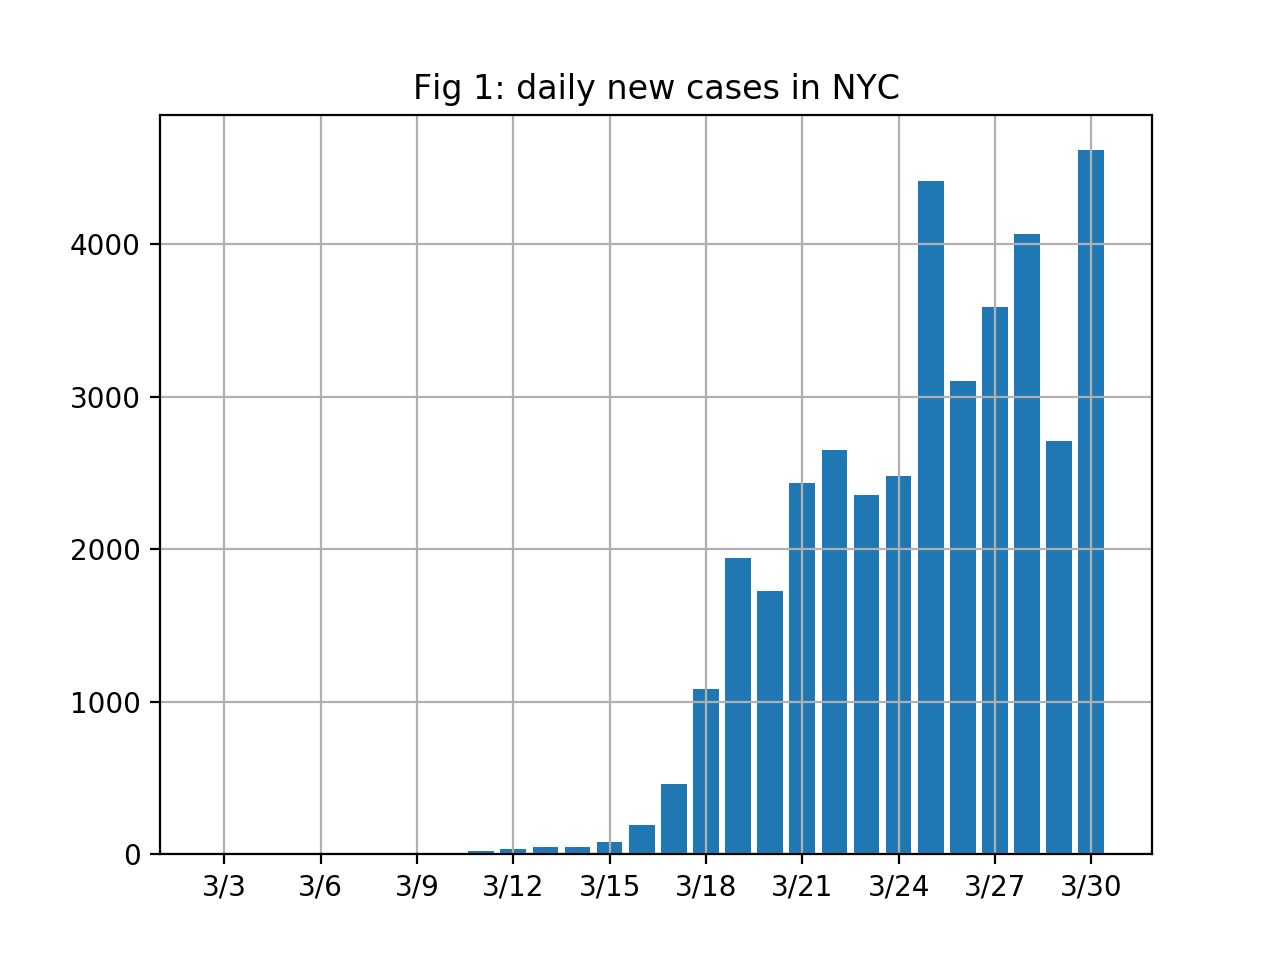

In [4]:
num_figs += 1
fig, ax = plt.subplots()
days = get_days(start_date, num_days)
ax.bar(days, C)
ax.set_title("Fig {}: daily new cases in NYC".format(num_figs))
formatter = mdates.DateFormatter('%-m/%-d')
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(left=start_date)
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


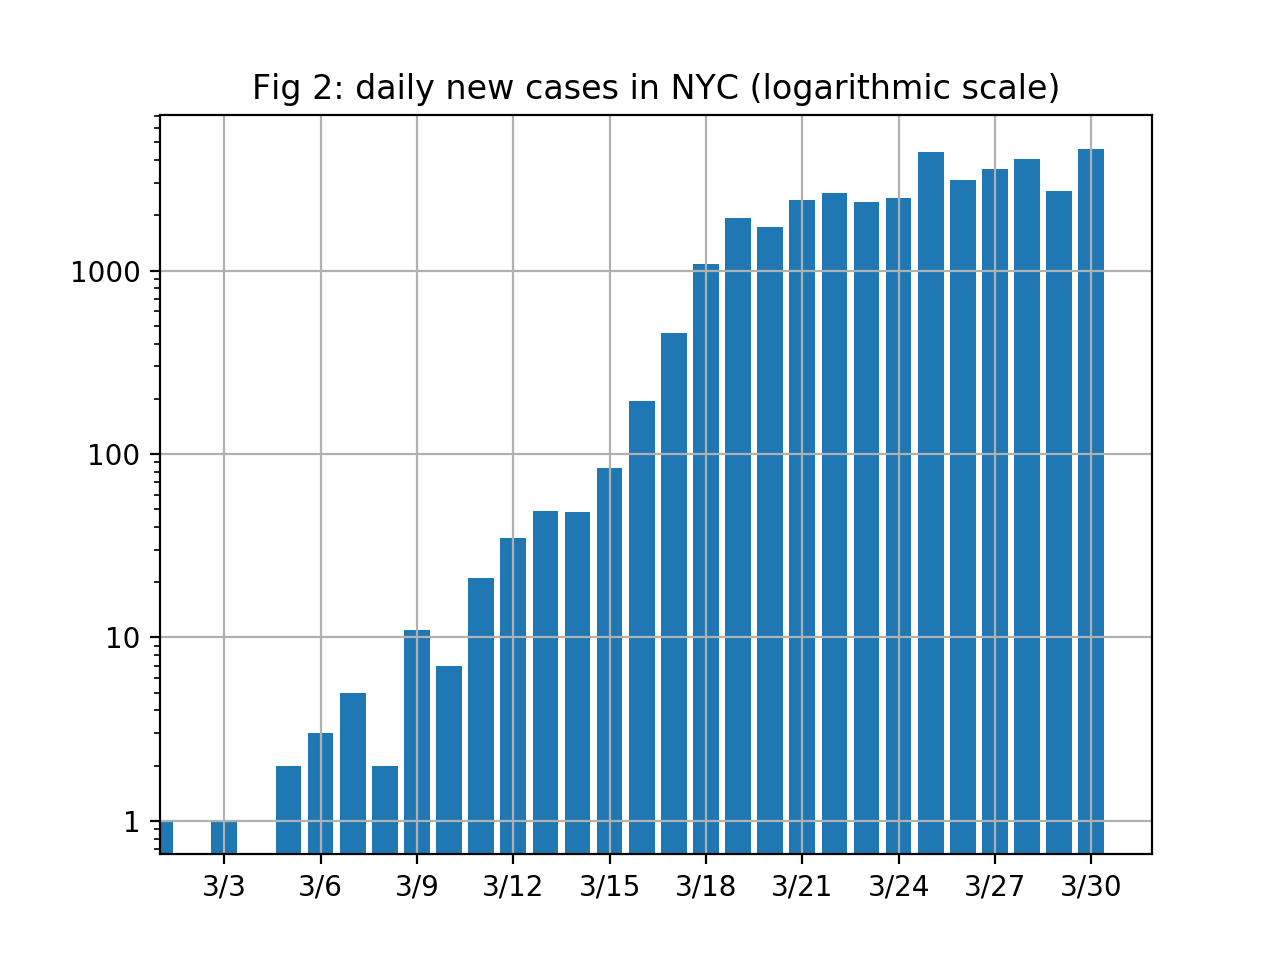

In [5]:
num_figs +=1
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots()
ax.bar(days, C)
ax.set_title("Fig {}: daily new cases in NYC (logarithmic scale)".format(num_figs))
formatter = mdates.DateFormatter('%-m/%-d')
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(left=start_date)
plt.grid()
plt.show()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


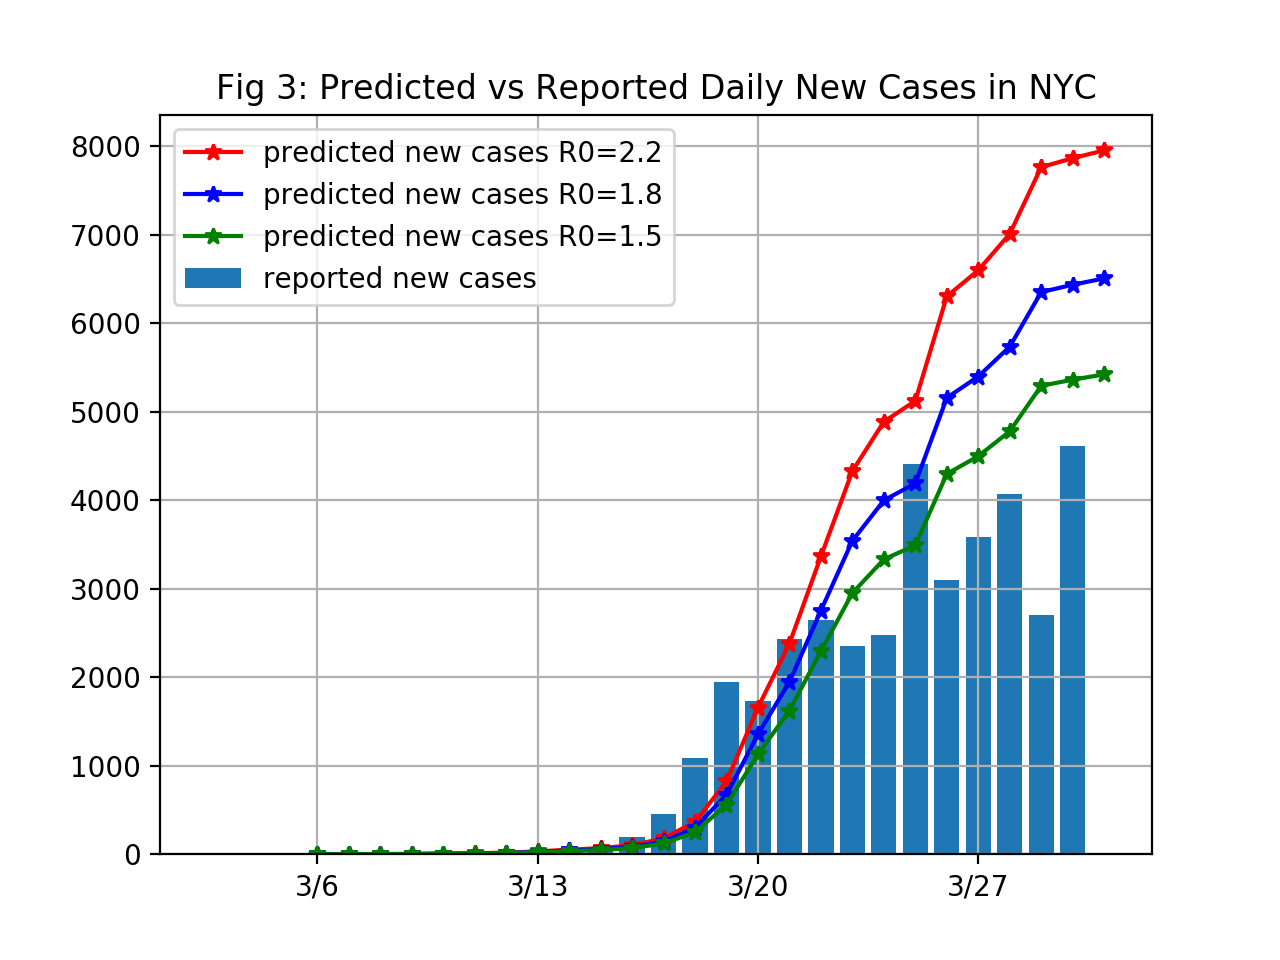

In [6]:
location="NYC"; 
# population of NYC, source: https://en.wikipedia.org/wiki/Boroughs_of_New_York_City
S0 = 8398748 

num_figs += 1
fig = plt.figure()
ax = fig.gca()
days = get_days(start_date, len(C))
ax.bar(days, C, label="reported new cases")

N = 5
for R0, color in zip([2.2, 1.8, 1.5],['r', 'b', 'g'])  :
    pred_C = predict_daily_new_cases(R0, N, C, S0)
    #  can predict only after N days from start
    pred_start_date = start_date + dt.timedelta(days=N) 
    pred_days = get_days(pred_start_date, len(pred_C))
    ax.plot(pred_days, pred_C, marker='*', label="predicted new cases R0={}".format(R0), color=color)

ax.legend()
plt.title("Fig {}: Predicted vs Reported Daily New Cases in {}".format(num_figs,location))
formatter = mdates.DateFormatter('%-m/%-d')
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(left=start_date)
plt.grid(True)
plt.show()

R0, the basic reproductive number, for Covid19 has been estimated to 2.2 based on scientific study done on cases from Diamond Cruise ship [Zhang et al. 2020](https://www.ijidonline.com/article/S1201-9712(20)30091-6/fulltext). Similarly, average incubation period for Covid19 outbreak has been reported to be 5.2. Based on that I used three values of R0 : 2.2, 1.8, 1.5 to predict the daily news cases in NYC  for every day from 3/6/20 from reported cases for last N=5 days, as per this model.  

Figure 3 shows the result. Before 3/20/20, reported cases in NYC every day was increasing at rate even faster than even R0 = 2.2, while later it seemed to have slowed down.

Now, is this slowdown simply because of progress of the epidemic, i.e., a lot more people being infected and are no longer susceptible? If you look at the total number of infections, ~38K, it is still much smaller than total population of NYC. Thus R_adjust_factor should be really close to 1. To confirm this, R_adjust_factor is calculated and shown in Figure 4. And as expected, R_adjust_factor goes down from 1 over time, but it is still > 0.995

This tells us slowdown in spread of the infection is likely due to true change in rate of contacts with infected persons. Adjusted replacement number R', which is a measure of rate of infection-causing contacts with  infected, is plotted in Figure 5.

<IPython.core.display.Javascript object>


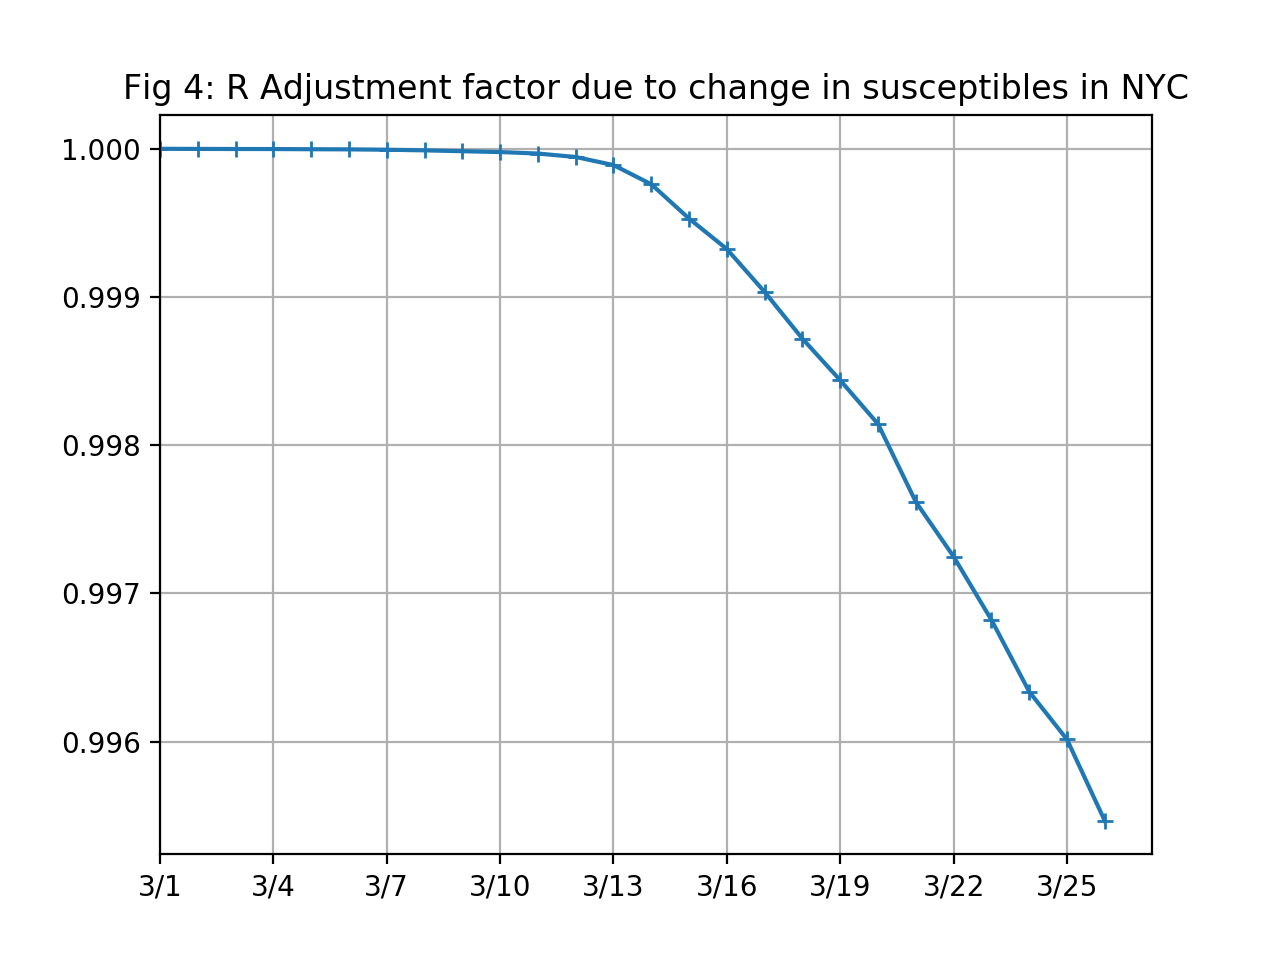

In [7]:
daily_R_adjf = calc_daily_R_adjust_factor(C, S0) 
num_figs += 1
fig = plt.figure()
ax = fig.gca()
days = get_days(start_date, len(daily_R_adjf))
ax.plot(days, daily_R_adjf, marker='+')
plt.title("Fig {}: R Adjustment factor due to change in susceptibles in {}".format(num_figs,location))
plt.xlim(left=start_date)
formatter = mdates.DateFormatter('%-m/%-d')
ax.xaxis.set_major_formatter(formatter)
plt.grid(True)


<IPython.core.display.Javascript object>


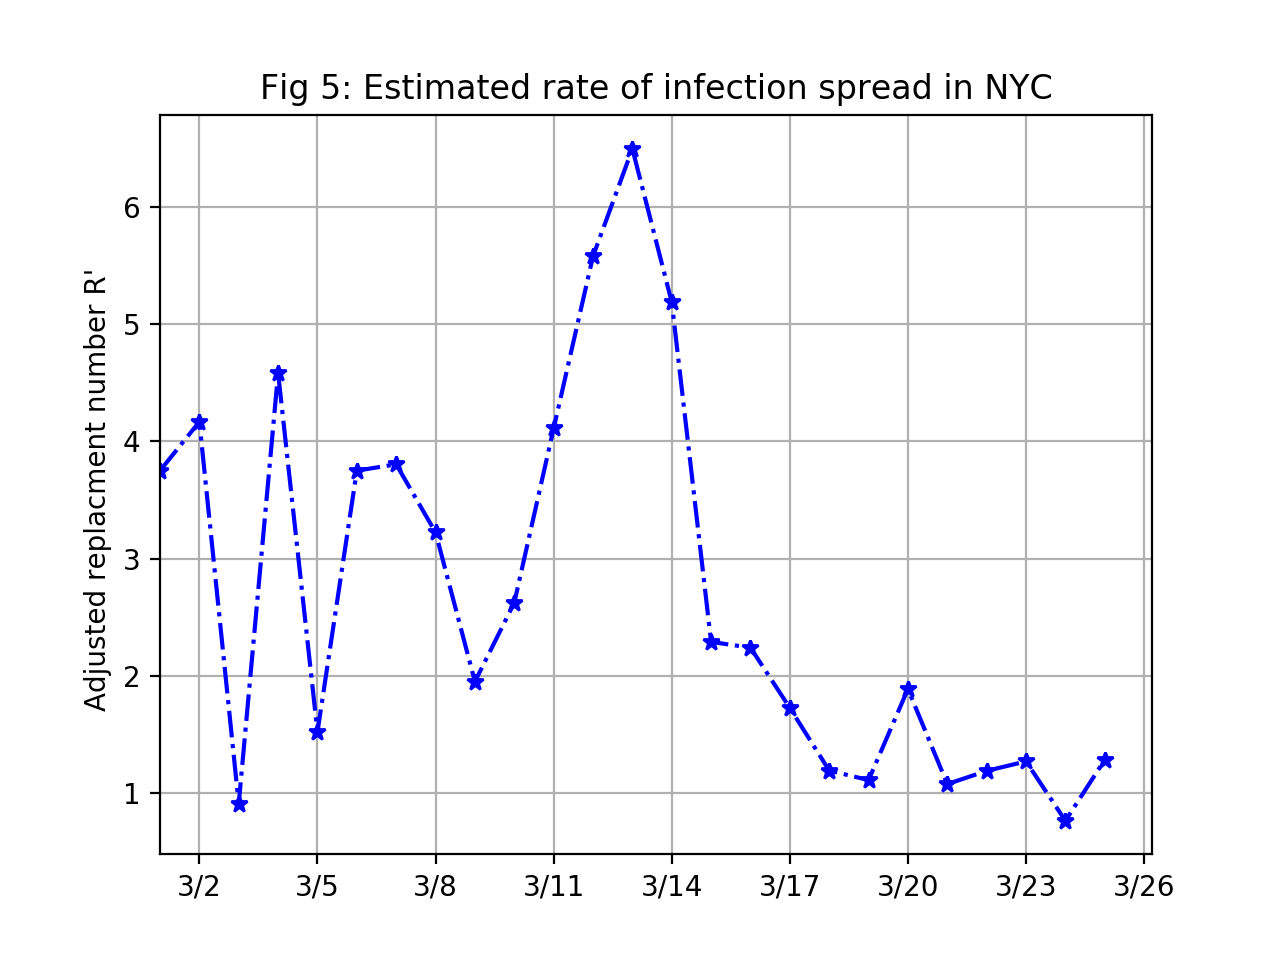

In [8]:
est_adjusted_R = estimate_daily_R(C,N,S0)
location="NYC"; start_x=1; 
num_figs += 1
fig = plt.figure()
ax = fig.gca()
days = get_days(start_date, len(est_adjusted_R))
ax.plot(days, est_adjusted_R, linestyle="-.", marker="*", color='b')
plt.title("Fig {}: Estimated rate of infection spread in {}".format(num_figs,location))
plt.ylabel("Adjusted replacment number R' ")
plt.grid(True, which="both", axis='both')
formatter = mdates.DateFormatter('%-m/%-d')
ax.xaxis.set_major_formatter(formatter)
plt.xlim(left=start_date)
plt.show()
    

Figure 5 shows adjusted replacement number R' is decreasing since about last two weeks. This indicates less and less new infections are being caused from each infected. This probably means social distancing and public health order such as  shleter-in-place is working for NYC. When R' goes and stays below 1, the epidemic has already peaked and on a downward trajectory. 

## Analysis of Covid19 data from Travis County, Austin, Texas

In [9]:
travis_cty_total_cases = [3,3,5,6,17,23,41,58,73,91,100,113,119,137,160,179, 200, 206, 244, 305, 351, 430]
start_date = dt.datetime(2020,3,13) # 3/13/2020
# sources : http://www.austintexas.gov/COVID19
# data points for 03/14 and 03/15 are corrected using internet wayback machine snapshot of the above website.

In [10]:
# total cases per day
T = np.array(travis_cty_total_cases)
# new cases per day
C = get_daily_new_from_total_cases(T)
start_date_str = start_date.strftime("%-m/%-d/%y")
num_days = len(C)
print("Number of data points: {} starting from {}".format(num_days, start_date_str))

Number of data points: 22 starting from 3/13/20


In [11]:
R0 = 2.2
N = 5
S0 = 1227771 # population of travis county, TX source: https://worldpopulationreview.com/us-counties/tx/travis-county-population/
pred_C = predict_daily_new_cases(R0, N, C, S0)
#print(pred_C)

<IPython.core.display.Javascript object>


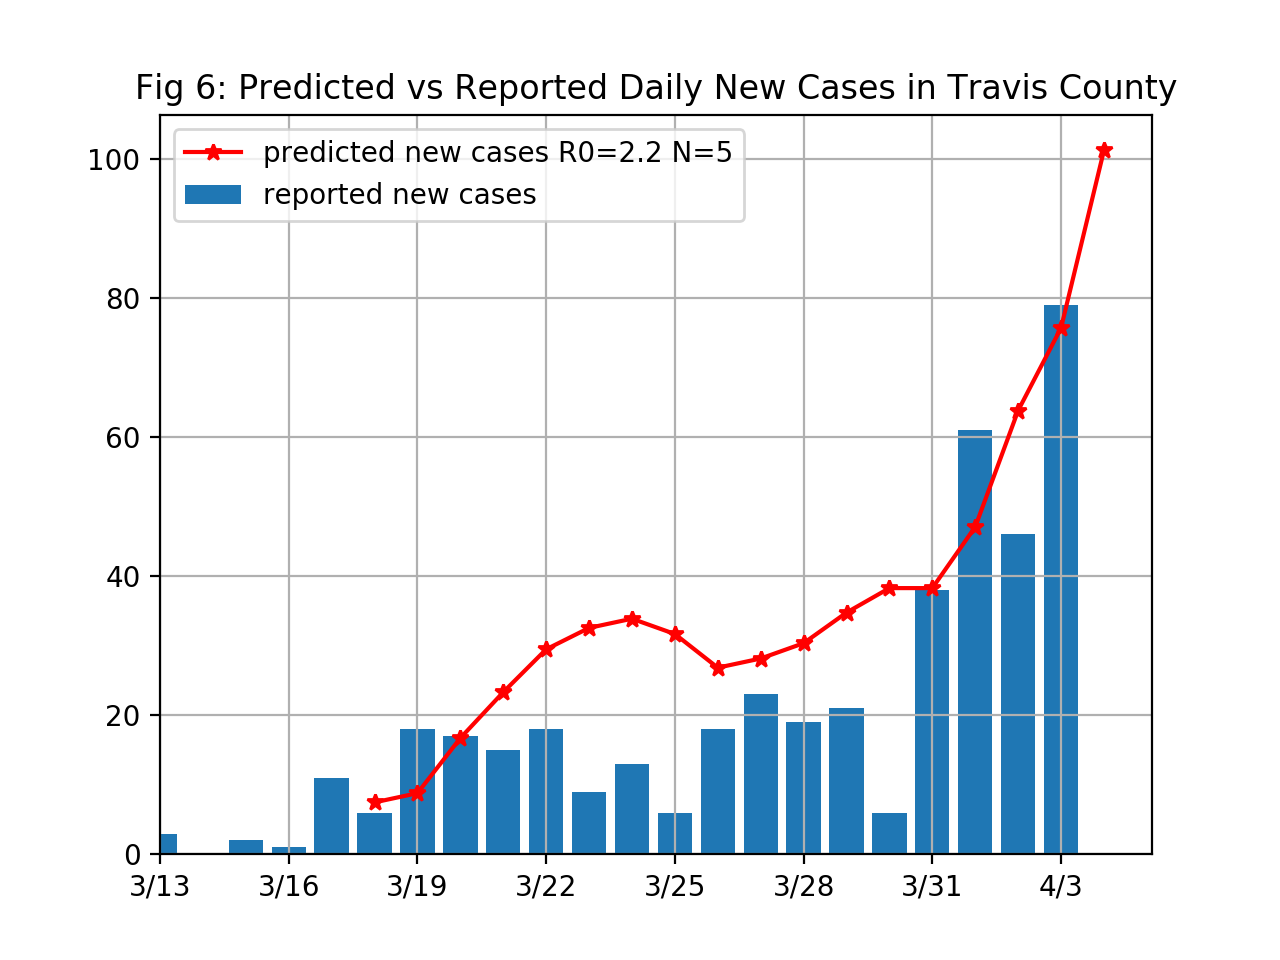

In [12]:
location="Travis County";N=5

num_figs += 1
fig = plt.figure()
ax = fig.gca()

days = get_days(start_date, len(C))
ax.bar(days, C, label="reported new cases")

pred_start_date = start_date + dt.timedelta(days=N)
#  can predict only after N days from start
pred_days = get_days(pred_start_date, len(pred_C))
ax.plot(pred_days, pred_C, marker='*', label="predicted new cases R0={} N={}".format(R0,N), color='r')

ax.legend()
plt.title("Fig {}: Predicted vs Reported Daily New Cases in {}".format(num_figs,location))
formatter = mdates.DateFormatter('%-m/%-d')
ax.xaxis.set_major_formatter(formatter)
plt.xlim(left=start_date)
plt.grid(True)
plt.show()
    

<IPython.core.display.Javascript object>


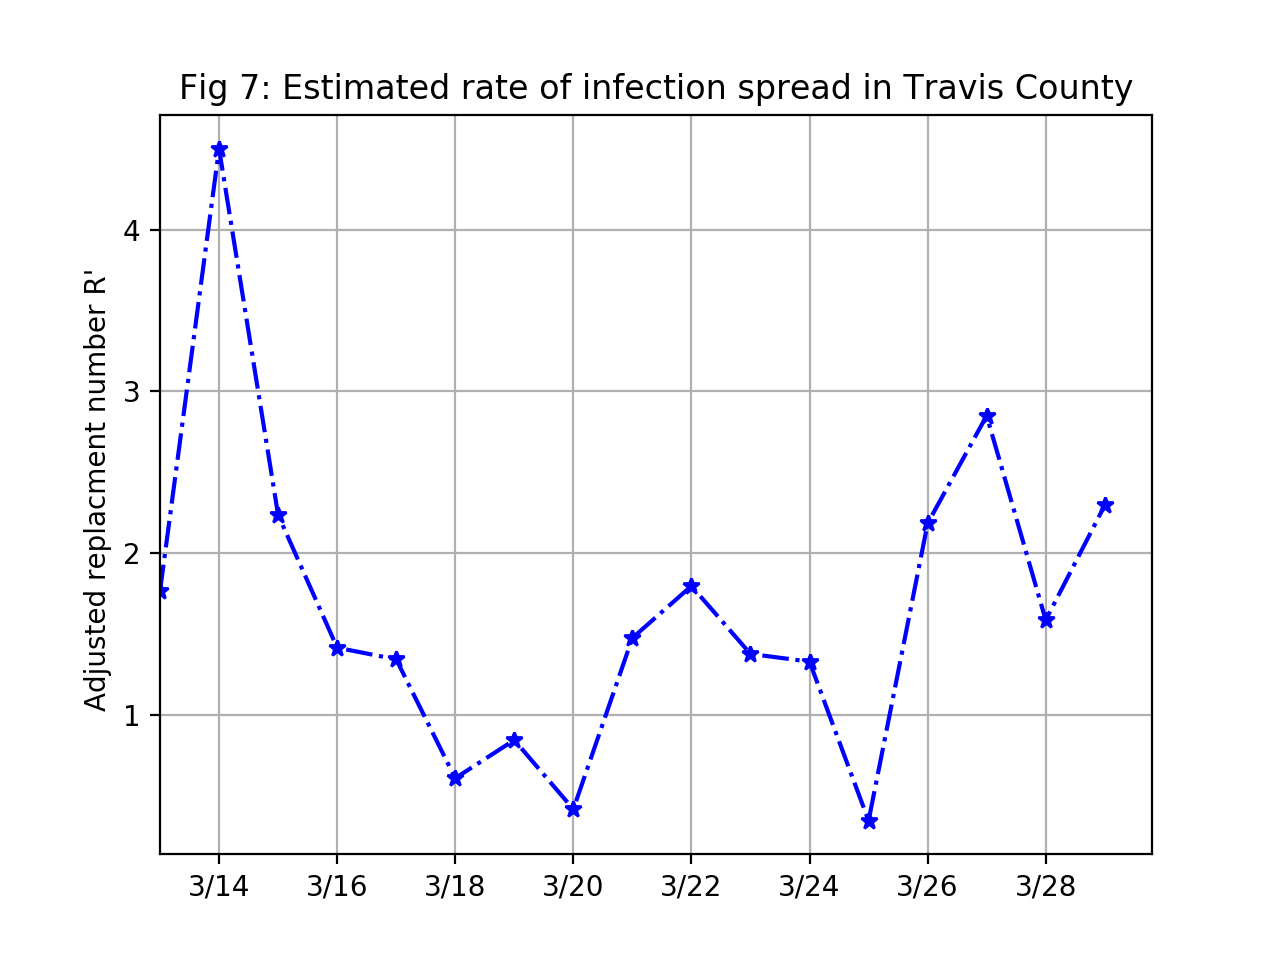

In [13]:
est_adjusted_R = estimate_daily_R(C,N,S0)
location="Travis County" 
num_figs += 1
fig = plt.figure()
ax = fig.gca()
days = get_days(start_date, len(est_adjusted_R))
ax.plot(days, est_adjusted_R, linestyle="-.", marker="*", color='b')
plt.title("Fig {}: Estimated rate of infection spread in {}".format(num_figs,location))
plt.ylabel("Adjusted replacment number R' ")
plt.grid(True, which="both", axis='both')
formatter = mdates.DateFormatter('%-m/%-d')
ax.xaxis.set_major_formatter(formatter)
plt.xlim(left=start_date)
plt.show()

Figure 7 show the rate at which the infection is spreading in Travis County, Austin, TX. It seemed to be decreasing shortly after the start of the outbreak but is climbing up back again. This is despite the shelter-in-place order issued for Travis County on 3/24.



## Analysis of Covid19 data from India

In [14]:
india_daily_total_cases = np.array([0,0,0,0,0,0,0,0,1,1,1,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,5,5,28,30,31,34,39,43,56,62,73,82,102,113,119,142,156,194,244,330,396,499,536,657,727,887,987,1024,1251,1397,1998])
start_date=dt.datetime(2020,1,22)

In [15]:
# looking at cases from March 1st
T = np.array(india_daily_total_cases[39:])
start_date=dt.datetime(2020,3,1)

In [16]:
# new cases per day
C = get_daily_new_from_total_cases(T)
start_date_str = start_date.strftime("%-m/%-d/%y")
num_days = len(C)
print("Number of data points: {} starting from {}".format(num_days, start_date_str))

Number of data points: 32 starting from 3/1/20


In [17]:
R0 = 2.2
N = 5
S0 = 1.377e9 # population of India
pred_C = predict_daily_new_cases(R0, N, C, S0)
#len(pred_C)

<IPython.core.display.Javascript object>


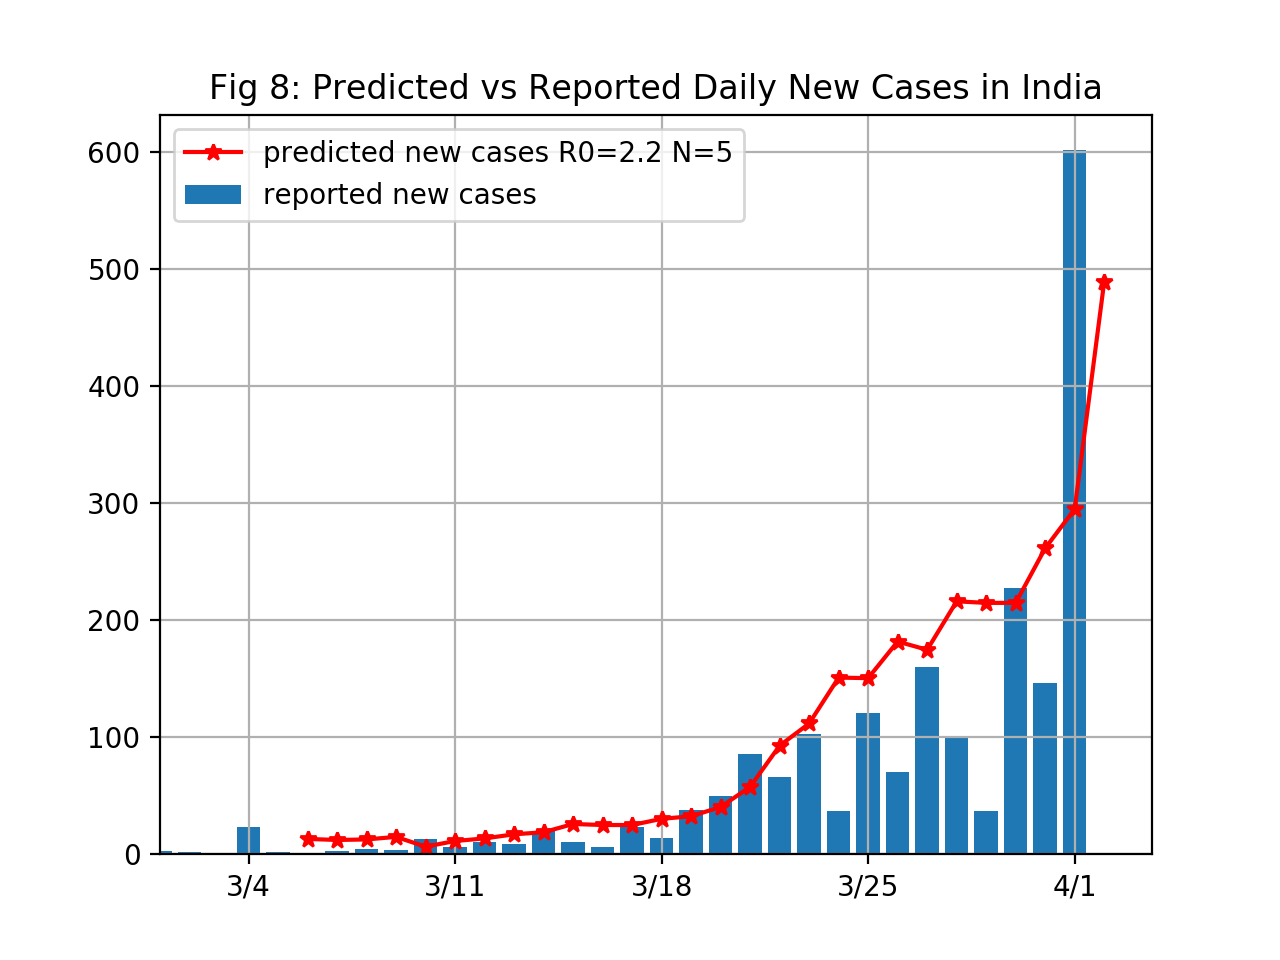

In [18]:
location="India";N=5

num_figs += 1
fig = plt.figure()
ax = fig.gca()

days = get_days(start_date, len(C))
ax.bar(days, C, label="reported new cases")

pred_start_date = start_date + dt.timedelta(days=N)
#  can predict only after N days from start
pred_days = get_days(pred_start_date, len(pred_C))
ax.plot(pred_days, pred_C, marker='*', label="predicted new cases R0={} N={}".format(R0,N), color='r')


ax.legend()
plt.title("Fig {}: Predicted vs Reported Daily New Cases in {}".format(num_figs,location))
formatter = mdates.DateFormatter('%-m/%-d')
ax.xaxis.set_major_formatter(formatter)
plt.xlim(left=start_date)
plt.grid(True)
plt.show()
    

<IPython.core.display.Javascript object>


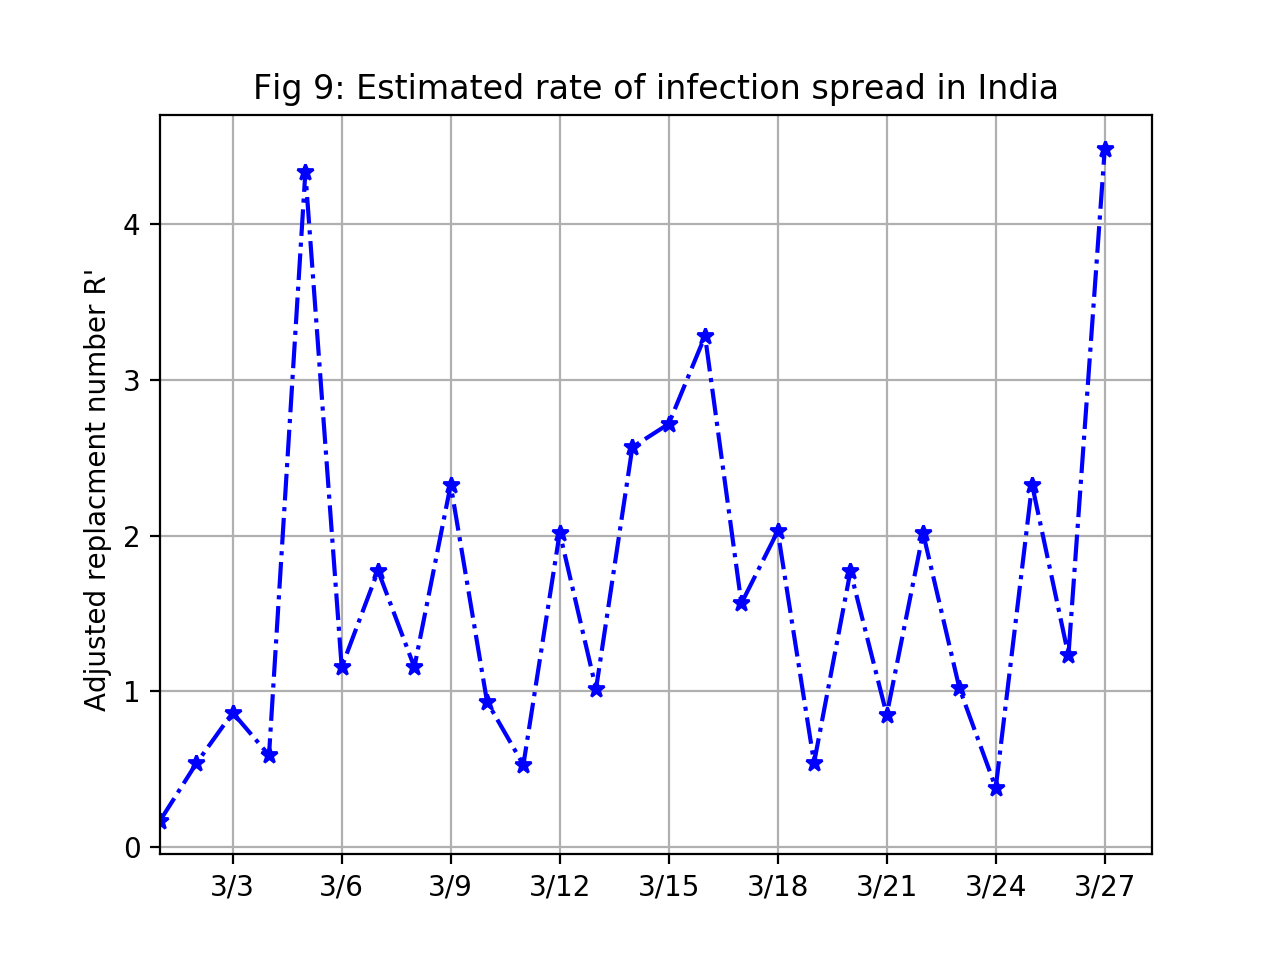

In [19]:
est_adjusted_R = estimate_daily_R(C,N,S0)
location="India"
num_figs += 1
fig = plt.figure()
ax = fig.gca()
days = get_days(start_date, len(est_adjusted_R))
ax.plot(days, est_adjusted_R, linestyle="-.", marker="*", color='b')
plt.title("Fig {}: Estimated rate of infection spread in {}".format(num_figs,location))
plt.ylabel("Adjusted replacment number R' ")
plt.grid(True, which="both", axis='both')
formatter = mdates.DateFormatter('%-m/%-d')
ax.xaxis.set_major_formatter(formatter)
plt.xlim(left=start_date)
plt.show()

Figure 9 shows the estimated rate at which the infection is spreading in India. I do not see any clear trend. It does not show any clear effect of social distancing or lockdown.  